Desenvolvido por: Arthur Lima Machado de Santana.
--------------------------------------------------------------------------------
Esse trabalho mostra como alguns recursos em SQL podem ser utilizados para realização de análise de dados em Python.

Para isso, foram utilizados os datasets de acidentes de trânsito disponíveis no site oficial da ANTT

In [7]:
#Exemplo de análise de dados de dataset online usando SQL em Python:

#Importando bibliotecas:
import pandas as pd
import sqlite3
import seaborn as sns
from matplotlib import pyplot as plt

#Importar dataset disponível online no site da ANTT:
url = 'https://dados.antt.gov.br/dataset/8a57b663-2302-405a-bf5a-cbece12c13d1/resource/4606a519-079e-4654-bcfe-9591e8d8051d/download/demostrativo_acidentes_viabahia.csv'
acidentes_ba = pd.read_csv(url, sep =';', encoding='utf-8')

# Criar uma conexão com um banco de dados SQLite
conn = sqlite3.connect('acidentes_ba_sql.db')

# Salvar o DataFrame no banco de dados SQLite
acidentes_ba.to_sql('acidentes_ba_sql', conn, index=False, if_exists='replace')

# Criar uma conexão com um banco de dados SQLite
conn = sqlite3.connect('acidentes_ba_sql.db')

In [8]:
#Primeira olhada na base de dados:
acidentes_ba

,Concessionaria,Data,Km,Trecho
0,VIA BAHIA,01/04/2010,520.0,BR-324/BA
1,VIA BAHIA,01/04/2010,523.0,BR-324/BA
2,VIA BAHIA,01/04/2010,538.0,BR-324/BA
3,VIA BAHIA,01/04/2010,538.0,BR-324/BA
4,VIA BAHIA,01/04/2010,558.0,BR-324/BA
...,...,...,...,...
47656,VIA BAHIA,30/06/2024,810.0,BR-116/BA
47657,VIA BAHIA,30/06/2024,851.0,BR-116/BA
47658,VIA BAHIA,30/06/2024,855.0,BR-116/BA
47659,VIA BAHIA,30/06/2024,861.0,BR-116/BA


In [9]:
# Cláusila WHERE (coleta dos acidentes em 2024):
query = "SELECT Trecho, COUNT(Trecho) FROM acidentes_ba_sql WHERE SUBSTRING(Data, -4) = '2024' GROUP BY Trecho ORDER BY COUNT(Trecho) DESC"
df = pd.read_sql(query, conn)
df

,Trecho,COUNT(Trecho)
0,BR-324/BA,909
1,BR-116/BA,686
2,CONTORNO - VC/BA,59
3,BR-116/BA - Cont VC,38
4,CONTORNO SUL - FS/BA,19
5,BR-116/BA - ContSuFS,14
6,BA-526,6
7,528/BA,2
8,526/BA,2


Análise em Pareto identifica os trechos com maior ocorrência e seu % acumulado. Isso permite ao tomador de decisão focar as análises e esforços nos locais que representam a maior parte dos acidentes.

C:\Users\User\AppData\Local\Temp\ipykernel_19812\3364359064.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(df['Trecho'], rotation=45)


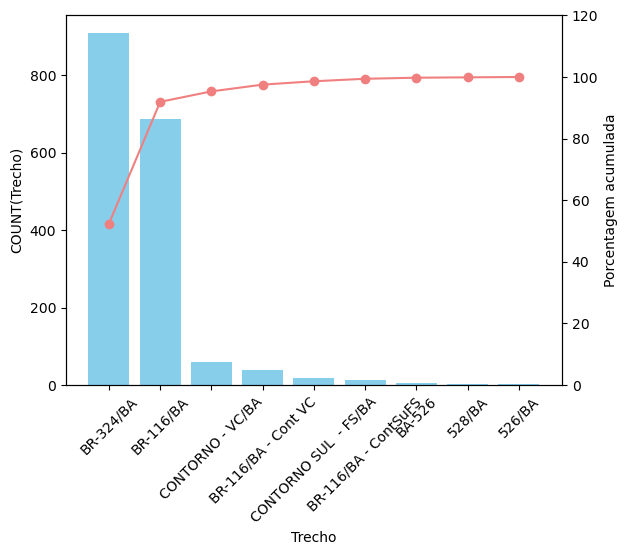

In [10]:
# Calculando a porcentagem acumulada
df['Porcentagem'] = (df['COUNT(Trecho)'].cumsum() / df['COUNT(Trecho)'].sum()) * 100

# Plotando o gráfico de Pareto
fig, ax1 = plt.subplots()

ax1.bar(df['Trecho'], df['COUNT(Trecho)'], color='skyblue')
ax1.set_xlabel('Trecho')
ax1.set_ylabel('COUNT(Trecho)')
ax1.set_xticklabels(df['Trecho'], rotation=45)

ax2 = ax1.twinx()
ax2.plot(df['Trecho'], df['Porcentagem'],color='lightcoral', marker='o')
ax2.set_ylabel('Porcentagem acumulada')
ax2.set_ylim(0, 120)

plt.show()

Identificando os "Km" com maior frequencia no trecho de maior número de acidentes, obvervado na análise anterior (pareto):

In [11]:
query = "SELECT Trecho ,Km, COUNT(Km) FROM acidentes_ba_sql WHERE SUBSTRING(Data, -4) = '2024' AND Trecho = 'BR-324/BA' GROUP BY Km ORDER BY COUNT(Km) DESC"

df1=pd.read_sql(query, conn).head(10)
df1

,Trecho,Km,COUNT(Km)
0,BR-324/BA,623.0,34
1,BR-324/BA,530.0,34
2,BR-324/BA,616.0,24
3,BR-324/BA,622.0,23
4,BR-324/BA,535.0,22
5,BR-324/BA,621.0,20
6,BR-324/BA,615.0,20
7,BR-324/BA,613.0,19
8,BR-324/BA,619.0,18
9,BR-324/BA,614.0,18


Realizando um mapa de calor para análise da distribuição temporal de ocorrência nas kilometragens do trecho com maior número de acidentes:

c:\Users\User\anaconda3\Lib\site-packages\seaborn\matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


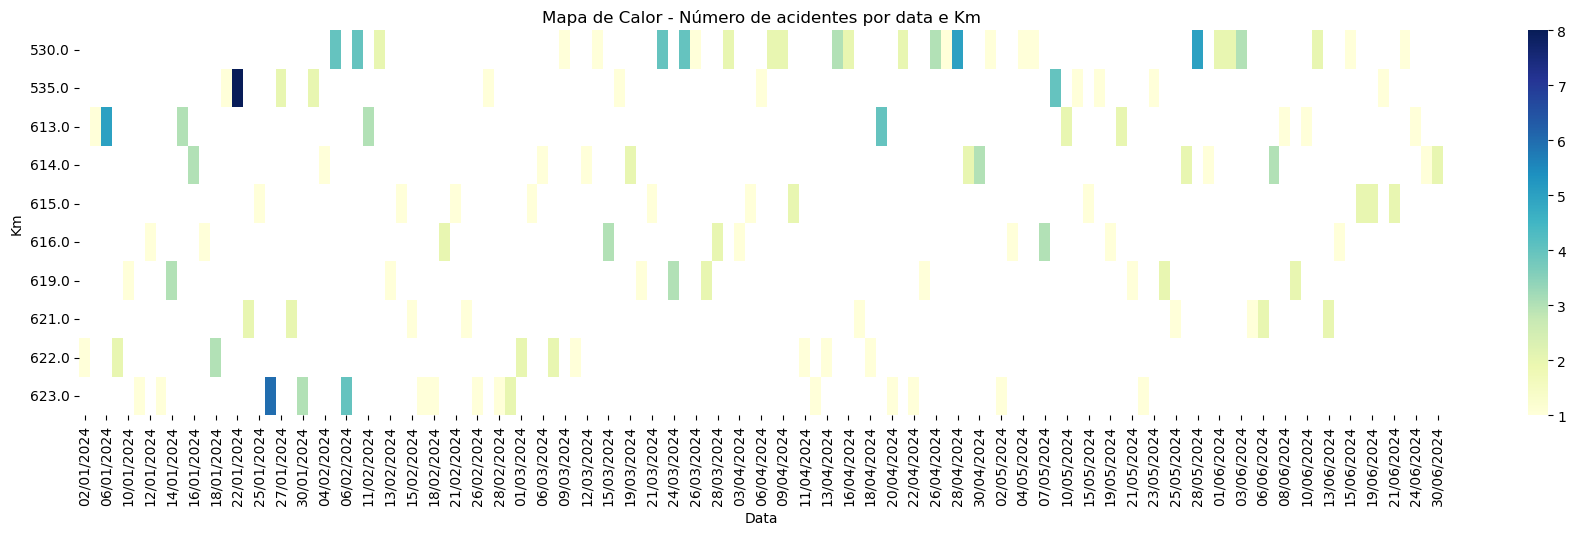

In [12]:
# Cláusila JOIN para coleta da string das kilometragens de maior ocorrência (coleta dos acidentes em 2024):
lista_km = df1['Km'].to_list()
lista_km_str = ', '.join(map(str, lista_km))

query = f"SELECT Trecho, Data, Km, COUNT(Km) FROM acidentes_ba_sql WHERE SUBSTRING(Data, -4) = '2024' AND Trecho = 'BR-324/BA' AND Km IN ({lista_km_str}) GROUP BY Data"

df=pd.read_sql(query, conn)
df['Data'] = pd.to_datetime(df['Data'], format='%d/%m/%Y')

# Mapa de Calor em Seaborn
pivot_table = df.pivot_table(index='Km', columns='Data', values='COUNT(Km)', aggfunc='first')
pivot_table = pivot_table.reindex(sorted(pivot_table.columns), axis=1)
pivot_table.columns = pivot_table.columns.strftime('%d/%m/%Y')

plt.figure(figsize=(22, 5))
sns.heatmap(pivot_table, cmap='YlGnBu', annot=True, fmt='g')
plt.title('Mapa de Calor - Número de acidentes por data e Km')
plt.xlabel('Data')
plt.ylabel('Km')

plt.show()